In [23]:

# Install nightly package for some functionalities that aren't in alpha
%pip install tf-nightly-gpu-2.0-preview
%pip install tf-hub-nightly
#%pip install tensorflow==2.0.0-alpha
%pip install tensorflow-hub==0.5
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tf-nightly-gpu-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-gpu-2.0-preview



  Using cached tensorflow_hub-0.5.0-py2.py3-none-any.whl (78 kB)
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.13.0
    Uninstalling tensorflow-hub-0.13.0:
      Successfully uninstalled tensorflow-hub-0.13.0
Note: you may need to restart the kernel to use updated packages.


In [24]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras import optimizers




In [7]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.12.0
Eager mode:  True
Hub version:  0.13.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


In [27]:
import zipfile

zip_file = tf.keras.utils.get_file(origin="https://github.com/AveyBD/rice-leaf-diseases-detection/raw/master/rice-leaf.zip", 
                                   fname='rice-leaf.zip', extract=True)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/rice-leaf-diseases-detection-master/')

In [28]:
data_dir = os.path.join(os.path.dirname(zip_file), 'content', 'rice')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [29]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [30]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : C:\Users\magan\.keras\datasets\content\rice\train : 157files
total images for validation : C:\Users\magan\.keras\datasets\content\rice\validation : 84files


In [32]:
import unzip 
import wget 
!!wget https://github.com/AveyBD/rice-leaf-diseases-detection/archive/master.zip
!unzip master.zip;

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [33]:
import json

with open('E:\pa\classes.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Bacterial_leaf_blight', 'blast', 'brownspot']


In [34]:
print('Number of classes:',len(classes))


Number of classes: 3


In [35]:

module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


In [36]:
#Data Preprocessing
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 84 images belonging to 3 classes.
Found 157 images belonging to 3 classes.


In [37]:
feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape=IMAGE_SIZE + (3,),
    output_shape=[FV_SIZE]
)

In [38]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [39]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Cause: Unable to locate the source code of <bound method KerasLayer.call of <tensorflow_hub.keras_layer.KerasLayer object at 0x0000019552791C40>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <bound method KerasLayer.call of <tensorflow_hub.keras_layer.KerasLayer object at 0x0000019552791C40>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <bound method KerasLayer.call of <tensorflow_hub.keras_layer.KerasLayer object at 0x0000019552791C40>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 den

In [40]:
#Compile model specifying the optimizer learning rate
#Specify Loss function and optimizers
LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [41]:
#Train Model
EPOCHS=30 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

C:\Users\magan\AppData\Local\Temp\ipykernel_19588\398827761.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
2/2 [==============================] - 10s 5s/step - loss: 3.0866 - accuracy: 0.4194 - val_loss: 2.8249 - val_accuracy: 0.3594
Epoch 2/30
2/2 [==============================] - 5s 4s/step - loss: 2.2451 - accuracy: 0.4624 - val_loss: 1.4978 - val_accuracy: 0.6719
Epoch 3/30
2/2 [==============================] - 6s 3s/step - loss: 0.9462 - accuracy: 0.6250 - val_loss: 1.1181 - val_accuracy: 0.4688
Epoch 4/30
2/2 [==============================] - 5s 3s/step - loss: 0.7910 - accuracy: 0.6667 - val_loss: 1.5430 - val_accuracy: 0.2656
Epoch 5/30
2/2 [==============================] - 5s 3s/step - loss: 0.7255 - accuracy: 0.6774 - val_loss: 1.0300 - val_accuracy: 0.5312
Epoch 6/30
2/2 [==============================] - 6s 4s/step - loss: 0.4976 - accuracy: 0.7969 - val_loss: 0.6554 - val_accuracy: 0.7500
Epoch 7/30
2/2 [==============================] - 6s 4s/step - loss: 0.4148 - accuracy: 0.8750 - val_loss: 0.7256 - val_accuracy: 0.7031
Epoch 8/30
2/2 [========================

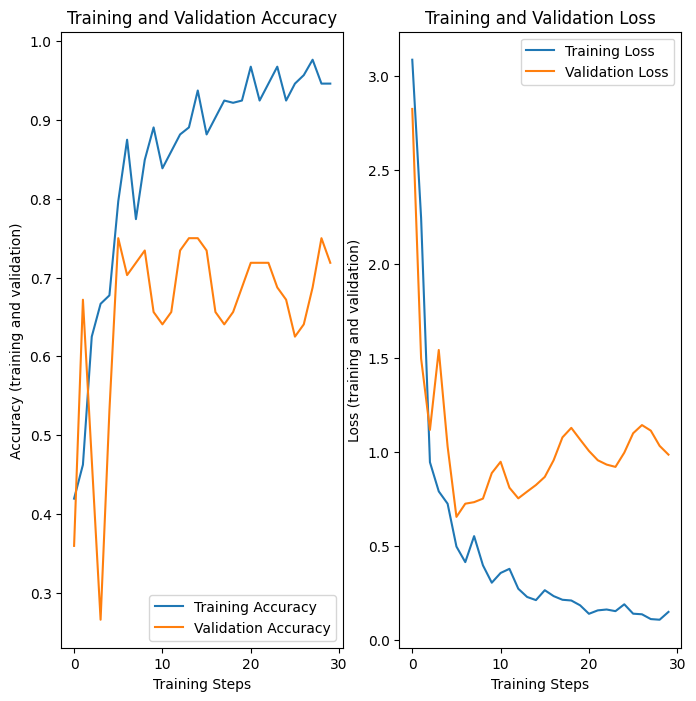

In [42]:
# Check Performance
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [47]:
#Random Test

# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(src):
    img = cv2.imread(os.path.join(data_dir, validation_dir, src))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(Lunar):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: blast, file: blast\blast_rotated_006.png
1/1 [==============================] - 0s 75ms/step
PREDICTED: class: blast, confidence: 0.943304


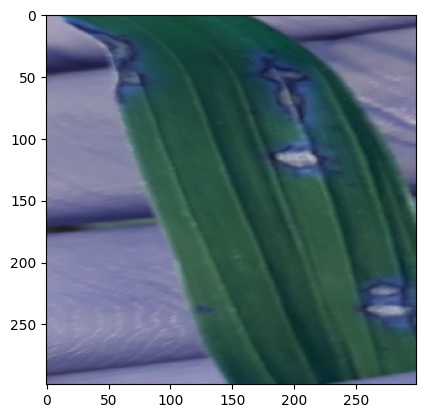

<Figure size 640x480 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight\blight_rotated_014.png
1/1 [==============================] - 0s 122ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.715169


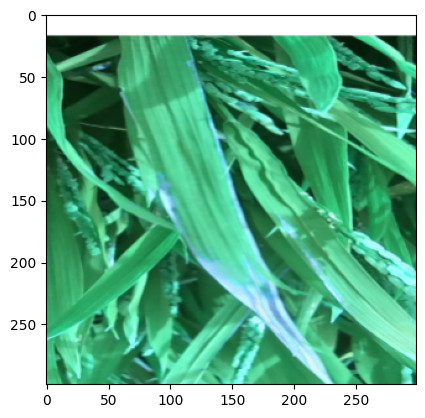

SOURCE: class: blast, file: blast\blast_rotated_002.png
1/1 [==============================] - 0s 72ms/step
PREDICTED: class: blast, confidence: 0.623049


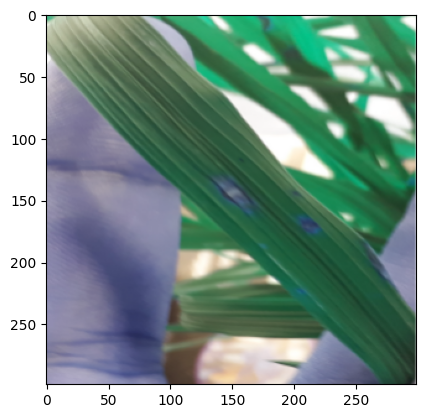

<Figure size 640x480 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight\blight_rotated_001.jpg
1/1 [==============================] - 0s 77ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.972493


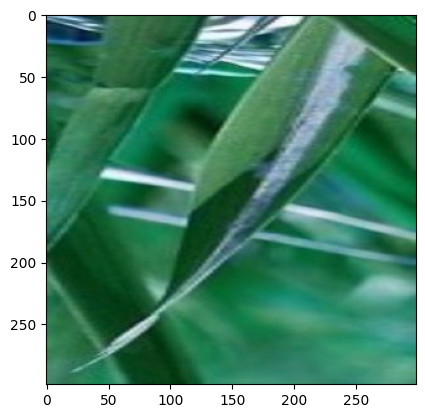

<Figure size 640x480 with 0 Axes>

SOURCE: class: brownspot, file: brownspot\brownspot_rotated_007.jpg
1/1 [==============================] - 0s 79ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.663102


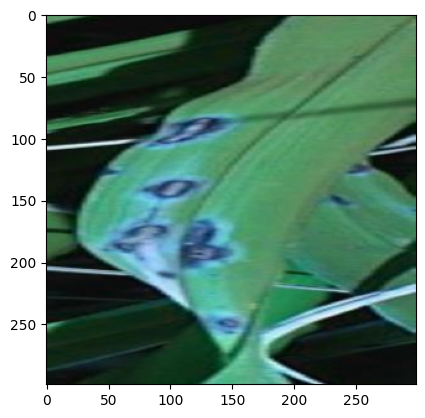

<Figure size 640x480 with 0 Axes>

In [48]:

for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [19]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""A Keras Layer for using TF Hub modules in TF2 format."""

import functools
import json

from absl import logging
import tensorflow as tf

from tensorflow_hub import module_v2

# pylint: disable=g-direct-tensorflow-import,g-import-not-at-top
from tensorflow.python.framework import smart_cond
from tensorflow.python.util import tf_inspect

try:
  from tensorflow.python.trackable import data_structures
except ImportError:
  from tensorflow.python.training.tracking import data_structures
# pylint: enable=g-direct-tensorflow-import,g-import-not-at-top


class KerasLayer(tf.keras.layers.Layer):
  """Wraps a SavedModel (or a legacy TF1 Hub format) as a Keras Layer.

  This layer wraps a callable object for use as a Keras layer. The callable
  object can be passed directly, or be specified by a Python string with a
  handle that gets passed to `hub.load()`.

  This is the preferred API to load a TF2-style SavedModel from TF Hub
  into a Keras model. Calling this function requires TF 1.15 or newer.
  It can be called both in eager and graph mode.

  The callable object is expected to follow the conventions detailed below.
  (These are met by TF2-compatible modules loaded from TensorFlow Hub.)

  The callable is invoked with a single positional argument set to one tensor
  or a nest of tensors containing the inputs to the layer. If the callable
  accepts a `training` argument, a Python boolean is passed for it. It is True
  if this layer is marked trainable *and* called for training, analogous to
  tf.keras.layers.BatchNormalization. (By contrast, tf.keras.layers.Dropout
  ignores the trainable state and applies the training argument verbatim.)

  If present, the following attributes of callable are understood to have
  special meanings:
    variables: a list of all tf.Variable objects that the callable depends on.
    trainable_variables: those elements of `variables` that are reported
      as trainable variables of this Keras Layer when the layer is trainable.
    regularization_losses: a list of callables to be added as losses of this
      Keras Layer when the layer is trainable. Each one must accept zero
      arguments and return a scalar tensor.

  Note: to work-around missing shape inference functionalities from functions
  created from FunctionDefs, in rare cases one has to pass an 'output_shape'
  and potentially 'input_shape' and 'dtype'. E.g. the following is a typical
  work-around:
  ```
  hub.KerasLayer(
      "/tmp/text_embedding_model",
      output_shape=[20],  # Outputs a tensor with shape [batch_size, 20].
      input_shape=[],     # Expects a tensor of shape [batch_size] as input.
      dtype=tf.string)    # Expects a tf.string input tensor.
  ```

  Note: This layer can be used inside the model_fn of a TF2 Estimator. See the
  [migration guide]
  (https://www.tensorflow.org/beta/guide/migration_guide#using_a_custom_model_fn)
  for guidance on how to pick up trainable variables, losses and updates
  explicitly from Keras objects instead of relying on graph collections.
  This layer class does not support graph collections.
  Distributed training of the Estimator requires setting the option
  `session_config.share_cluster_devices_in_session` within the
  `tf.estimator.RunConfig`. (This option was experimental from TF1.14 to TF2.1.)

  Note: The data types used by a saved model have been fixed at saving time.
  Using tf.keras.mixed_precision etc. has no effect on the saved model
  that gets loaded by a hub.KerasLayer.

  Attributes:
    handle: A callable object (subject to the conventions above), or a Python
      string to load a saved model via hub.load(). A string is required to save
      the Keras config of this Layer.
    trainable: Optional. A boolean controlling whether this layer is trainable.
      Must not be set to True when using a signature (raises ValueError),
      including the use of legacy TF1 Hub format.
    arguments: Optional. A dict with additional keyword arguments passed to the
      callable. These must be JSON-serializable to save the Keras config of this
      layer, and are not tracked as checkpointing dependencies of this layer.
    _sentinel: Used to prevent further positional arguments.
    tags: Optional. If set indicates which graph variant to use. For legacy
      models in TF1 Hub format leaving unset means to use the empty tags set.
    signature: Optional. If set, KerasLayer will use the requested signature.
      For legacy models in TF1 Hub format leaving unset means to use the
      `default` signature. When using a signature, either
      signature_outputs_as_dict or output_key have to set.
    signature_outputs_as_dict: If set to True, the call to this layer returns a
      dict of all the signature outputs. Can only be used if a signature is
      specified (or default signature is used for legacy models in TF1 Hub
      format).
    output_key: Name of the output item to return if the layer returns a dict.
      For legacy models in TF1 Hub format leaving unset means to return the
      `default` output.
    output_shape: A tuple or a nest of tuples with the (possibly partial) output
      shapes of the callable *without* leading batch size. This must have the
      same nesting structure as the output of the callable object and cover all
      output tensors.
    load_options: Optional, `tf.saved_model.LoadOptions` object that specifies
      options for loading when a Python string is provided as `handle`. This
      argument can only be used from TensorFlow 2.3 onwards.
    **kwargs: Forwarded to Keras' base Layer constructor.
  """

  def __init__(
      self,
      handle,
      trainable=False,
      arguments=None,
      _sentinel=None,  # pylint: disable=invalid-name
      tags=None,
      signature=None,
      signature_outputs_as_dict=None,
      output_key=None,
      output_shape=None,
      load_options=None,
      **kwargs):
    # Note: for compatibility with keras-model serialization this layer is
    # json-serializable. If you add or change arguments here, please also update
    # the `get_config` method.
    # The arguments are marked NoDependency to avoid autoconversion to a
    # trackable _DictWrapper, because that upsets json.dumps() when saving
    # the result of get_config().
    self._handle = handle
    self._arguments = data_structures.NoDependency(arguments or {})
    self._signature = signature
    self._signature_outputs_as_dict = signature_outputs_as_dict
    self._output_key = output_key
    if output_shape:
      # Autograph chokes on _convert_nest_to_shapes(), so we call it here
      # and not from within call().
      self._output_shape = data_structures.NoDependency(
          _convert_nest_to_shapes(output_shape))

    self._load_options = load_options
    self._func = load_module(handle, tags, self._load_options)
    self._is_hub_module_v1 = getattr(self._func, "_is_hub_module_v1", False)

    # Update with the defaults when using legacy TF1 Hub format.
    if self._is_hub_module_v1:
      self._signature = self._signature or "default"
      if not self._signature_outputs_as_dict:
        self._output_key = self._output_key or "default"
    # More validity checks.
    if self._signature and (bool(self._output_key is not None)
                            == bool(self._signature_outputs_as_dict)):
      raise ValueError("When using a signature, either output_key or "
                       "signature_outputs_as_dict=True should be set.")
    if not self._signature and self._signature_outputs_as_dict:
      raise ValueError("signature_outputs_as_dict is only valid if specifying "
                       "a signature (or using a legacy TF1 Hub format).")

    self._callable = self._get_callable()
    self._has_training_argument = func_has_training_argument(self._callable)
    self._setup_layer(trainable, **kwargs)

  def _setup_layer(self, trainable=False, **kwargs):
    """Constructs keras layer with relevant weights and losses."""
    # Initialize an empty layer, then add_weight() etc. as needed.
    super().__init__(trainable=trainable, **kwargs)

    # Add trainable and non-trainable weights from the callable.
    if hasattr(self._func, "trainable_variables"):
      for v in self._func.trainable_variables:
        self._add_existing_weight(v, trainable=True)
      trainable_variables = {id(v) for v in self._func.trainable_variables}
    else:
      trainable_variables = set()
    if hasattr(self._func, "variables"):
      for v in self._func.variables:
        if id(v) not in trainable_variables:
          self._add_existing_weight(v, trainable=False)

    # Forward the callable's regularization losses (if any).
    if hasattr(self._func, "regularization_losses"):
      for l in self._func.regularization_losses:
        if not callable(l):
          raise ValueError(
              "hub.KerasLayer(obj) expects obj.regularization_losses to be an "
              "iterable of callables, each returning a scalar loss term.")
        self.add_loss(self._call_loss_if_trainable(l))  # Supports callables.

  def _add_existing_weight(self, weight, trainable=None):
    """Calls add_weight() to register but not create an existing weight."""
    if trainable is None: trainable = weight.trainable
    self.add_weight(name=weight.name, shape=weight.shape, dtype=weight.dtype,
                    trainable=trainable, experimental_autocast=False,
                    getter=lambda *_, **__: weight)

  def _call_loss_if_trainable(self, loss):
    """Returns `loss` conditioned on whether this layer is trainable."""
    return lambda: loss() if self.trainable else 0.

  def call(self, inputs, training=None):
    # These checks happen here and not in __init__, because self.trainable is
    # a mutable public attribute.
    self._check_trainability()

    # We basically want to call this...
    args = []
    kwargs = self._arguments.copy()
    if self._signature and isinstance(inputs, dict):
      kwargs.update(inputs)
    else:
      args.append(inputs)
    f = functools.partial(self._callable, *args, **kwargs)
    # ...but we may also have to pass a Python boolean for `training`, which
    # is the logical "and" of this layer's trainability and what the surrounding
    # model is doing (analogous to tf.keras.layers.BatchNormalization in TF2).
    # For the latter, we have to look in two places: the `training` argument,
    # or else Keras' global `learning_phase`, which might actually be a tensor.
    if not self._has_training_argument:
      result = f()
    else:
      if self.trainable:
        if training is None:
          training = tf.keras.backend.learning_phase()
      else:
        # Behave like BatchNormalization. (Dropout is different, b/181839368.)
        training = False
      result = smart_cond.smart_cond(training,
                                     lambda: f(training=True),
                                     lambda: f(training=False))

    # Unwrap dicts returned by signatures.
    if self._output_key:
      if not isinstance(result, dict):
        raise ValueError("Specifying `output_key` is forbidden if output "
                         "type %s is not a dict." % type(result))
      if self._output_key not in result:
        raise ValueError(
            "KerasLayer output does not contain the output key %s "
            "(available: %s)." % (self._output_key, result.keys()))
      result = result[self._output_key]

    result = self._apply_output_shape_if_set(inputs, result)
    return result

  def _check_trainability(self):
    """Raises or logs errors for unuspported uses of trainable=True."""
    if not self.trainable: return  # Nothing to do.

    # Training is only supported when calling a reusable TF2 SavedModel through
    # its @tf.function __call__. Trying to train through a signature is likely
    # to go wrong beyond the most simple cases due to a number of pitfalls:
    # - No good support for train vs inference mode. TF1 Hub format used
    #   graph versions identified by tags, but this was not a general
    #   standard for SavedModels, and TF2 can no longer save with tags.
    # - No support for update ops. TF1 Hub format had them in the UPDATE_OPS
    #   collection, but collections are no longer loaded in TF2. General
    #   SavedModel signatures had no support for them.
    # - No support for regularization losses (same story).
    # - A SavedModel without @tf.function __call__ will likely also not
    #   provide a trainable_variables attribute.
    if self._is_hub_module_v1:
      raise ValueError(
          "Setting hub.KerasLayer.trainable = True is unsupported when "
          "loading from the TF1 Hub format.")
    elif self._signature:
      raise ValueError(
          "Setting hub.KerasLayer.trainable = True is unsupported when "
          "calling a SavedModel signature.")
    # Having zero trainable variables in an otherwise trainable model
    # is suspicious but may be valid as a boundary case, so we just log,
    # but at most once per layer instance.
    if not self.trainable_weights:
      if not hasattr(self, "_already_logged_trainable_with_zero_weights"):
        logging.error(
            "hub.KerasLayer is trainable but has zero trainable weights.")
        setattr(self, "_already_logged_trainable_with_zero_weights", True)

  def _get_callable(self):
    """Returns a callable object."""
    if callable(self._func) and not self._signature:
      return self._func
    if not hasattr(self._func, "signatures"):
      if self._signature:  # Assuming the user intended to use a signature.
        raise ValueError("Loaded object has no signatures.")
      else:  # Assuming the user intended to use a callable SavedModel.
        raise ValueError(
            "Loaded object is not callable and has no signatures.")
    if self._signature is None:
      raise ValueError("Signature name has to be specified for non-callable "
                       "saved models (if not legacy TF1 Hub format).")
    if self._signature not in self._func.signatures:
      raise ValueError("Unknown signature %s in %s (available signatures: %s)."
                       % (self._signature, self._handle, self._func.signatures))
    f = self._func.signatures[self._signature]
    if not callable(f):
      raise ValueError("Internal error: signature %s is not callable in %s" %
                       (self._signature, self._handle))
    return f

  def _apply_output_shape_if_set(self, inputs, outputs):
    if not hasattr(self, "_output_shape"):
      return outputs
    # Traverse the nest and turn shape-like tuples into tf.TensorShapes,
    # or else map_structure below would try to recurse into them.
    output_shape = getattr(self, "_output_shape")
    batch_size = tf.nest.flatten(inputs)[0].shape[0]
    def _inplace_set_shape(tensor, shape):
      tensor.set_shape(tf.TensorShape(batch_size).concatenate(shape))
    tf.nest.map_structure(_inplace_set_shape, outputs, output_shape)
    return outputs

  def get_config(self):
    """Returns a serializable dict of keras layer configuration parameters."""
    config = super().get_config()
    if not isinstance(self._handle, str):
      # Need to raise this type in order for tf.saved_model.save() to fall back
      # to not using config, instead of crashing.
      # TODO(b/134528831): Reconsider the usability implications.
      raise NotImplementedError(
          "Can only generate a valid config for `hub.KerasLayer(handle, ...)`"
          "that uses a string `handle`.\n\n"
          "Got `type(handle)`: {}".format(type(self._handle)))
    config["handle"] = self._handle

    if hasattr(self, "_output_shape"):
      output_shape = _convert_nest_from_shapes(self._output_shape)
      try:
        json.dumps(output_shape)
      except TypeError:
        raise ValueError(
            "hub.KerasLayer(..., output_shape=) is not json-serializable.\n"
            "Got value: {}".format(output_shape))
      config["output_shape"] = output_shape

    if self._arguments:
      # Raise clear errors for non-serializable arguments.
      for key, value in self._arguments.items():
        try:
          json.dumps(value)
        except TypeError:
          raise ValueError(
              "`hub.KerasLayer(..., arguments)` contains non json-serializable"
              "values in key: {}".format(key))
      config["arguments"] = self._arguments

    if self._signature:
      config["signature"] = self._signature
    if self._output_key:
      config["output_key"] = self._output_key
    if self._signature_outputs_as_dict:
      config["signature_outputs_as_dict"] = self._signature_outputs_as_dict

    # self._load_options is not stored in the config. Instead, the load
    # options passed at the time when this layer gets reloaded from its config
    # are applied to its own loading as well. That is because the only
    # load option available at this time (July 2020) is
    # `experimental_io_device`, which relates to the loading environment,
    # and not to the interpretation of the loaded SavedModel.

    return config

  @property
  def resolved_object(self):
    """Returns the callable object to which `handle` resolved in `__init__`."""
    return self._func

  def compute_output_shape(self, input_shape):
    """Computes the output shape of the layer.

    This relies on the `output_shape` provided during initialization, if any,
    else falls back to the default behavior from `tf.keras.layers.Layer`.

    Args:
      input_shape: Shape tuple (tuple of integers) or list of shape tuples (one
        per output tensor of the layer). Shape tuples can include None for free
        dimensions, instead of an integer.

    Returns:
      An input shape tuple.
    """
    if hasattr(self, "_output_shape"):
      output_shape = getattr(self, "_output_shape")
      batch_size = tf.nest.flatten(input_shape)[0]
      return tf.TensorShape((batch_size,)).concatenate(output_shape)

    return super(KerasLayer, self).compute_output_shape(input_shape)


def _convert_nest_to_shapes(x):
  """In a nest, converts raw tuples/lists of int or None to tf.TensorShape."""
  # A dict is certainly a container and not a shape. We need to handle
  # it first and not try construct a TensorShape from its keys.
  if isinstance(x, dict):
    return type(x)([(k, _convert_nest_to_shapes(v)) for k, v in x.items()])
  # Anything else might be already a TensorShape, a tuple that converts
  # to a TensorShape, or a sequence that needs further recursion.
  try:
    return tf.TensorShape(x)
  except TypeError:
    pass  # Will try parsing as a container instead.
  if isinstance(x, (list, tuple)):
    return type(x)([_convert_nest_to_shapes(v) for v in x])
  else:
    raise TypeError("Cannot convert to nest of TensorShapes, "
                    "found none of TensorShape, dict, list, tuple: %r" % x)


def _convert_nest_from_shapes(x):
  """Converts a nest of tf.TensorShape to raw tuples of int or None."""
  def _shape_as_tuple(x):
    assert isinstance(x, tf.TensorShape)
    return tuple(x.as_list())
  return tf.nest.map_structure(_shape_as_tuple, x)


def load_module(handle, tags=None, load_options=None):
  if callable(handle):
    if tags is not None:
      raise ValueError("Passing a callable handle is mutually exclusive "
                       "with setting tags.")
    if load_options is not None:
      raise ValueError("Passing a callable handle is mutually exclusive "
                       "with setting load_options.")
    return handle
  else:
    try:
      # pylint: disable=g-import-not-at-top
      from keras.saving.legacy.saved_model import load_context
      set_load_options = load_options or load_context.get_load_options()
    except ImportError:  # Expected before TF2.7 when keras is under tensorflow.
      try:
        # pylint: disable=g-import-not-at-top
        # pylint: disable=g-direct-tensorflow-import
        from tensorflow.python.keras.saving.saved_model import load_context
        set_load_options = load_options or load_context.get_load_options()
      except ImportError:  # Expected before TF2.5.
        try:
          # pylint: disable=g-import-not-at-top
          # pylint: disable=g-direct-tensorflow-import
          from tensorflow.python.saved_model import load_context
          set_load_options = load_options or load_context.get_load_options()
        except ImportError:  # Expected before TF2.4.
          set_load_options = load_options
    return module_v2.load(handle, tags=tags, options=set_load_options)


def func_has_training_argument(func):
  """Checks whether saved model has a `training` argument."""
  if not callable(func):
    return False
  fullargspec = tf_inspect.getfullargspec(func.__call__)
  return ("training" in fullargspec.args or
          "training" in fullargspec.kwonlyargs)


In [20]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""TensorFlow Hub Module API for Tensorflow 2.0."""

import os
import tensorflow as tf

from tensorflow_hub import native_module
from tensorflow_hub import registry


def resolve(handle):
  """Resolves a module handle into a path.

  This function works both for plain TF2 SavedModels and the legacy TF1 Hub
  format.

  Resolves a module handle into a path by downloading and caching in
  location specified by TFHUB_CACHE_DIR if needed.

  Currently, three types of module handles are supported:
    1) Smart URL resolvers such as tfhub.dev, e.g.:
       https://tfhub.dev/google/nnlm-en-dim128/1.
    2) A directory on a file system supported by Tensorflow containing module
       files. This may include a local directory (e.g. /usr/local/mymodule) or a
       Google Cloud Storage bucket (gs://mymodule).
    3) A URL pointing to a TGZ archive of a module, e.g.
       https://example.com/mymodule.tar.gz.

  Args:
    handle: (string) the Module handle to resolve.

  Returns:
    A string representing the Module path.
  """
  return registry.resolver(handle)


def load(handle, tags=None, options=None):
  """Resolves a handle and loads the resulting module.

  This is the preferred API to load a Hub module in low-level TensorFlow 2.
  Users of higher-level frameworks like Keras should use the framework's
  corresponding wrapper, like hub.KerasLayer.

  This function is roughly equivalent to the TF2 function
  `tf.saved_model.load()` on the result of `hub.resolve(handle)`. Calling this
  function requires TF 1.14 or newer. It can be called both in eager and graph
  mode.

  Note: Using in a tf.compat.v1.Session with variables placed on parameter
  servers requires setting `experimental.share_cluster_devices_in_session`
  within the `tf.compat.v1.ConfigProto`. (It becomes non-experimental in TF2.2.)

  This function can handle the deprecated TF1 Hub format to the extent
  that `tf.saved_model.load()` in TF2 does. In particular, the returned object
  has attributes
    * `.variables`: a list of variables from the loaded object;
    * `.signatures`: a dict of TF2 ConcreteFunctions, keyed by signature names,
      that take tensor kwargs and return a tensor dict.
  However, the information imported by hub.Module into the collections of a
  tf.Graph is lost (e.g., regularization losses and update ops).

  Args:
    handle: (string) the Module handle to resolve; see hub.resolve().
    tags: A set of strings specifying the graph variant to use, if loading from
      a v1 module.
    options: Optional, `tf.saved_model.LoadOptions` object that specifies
      options for loading. This argument can only be used from TensorFlow 2.3
      onwards.

  Returns:
    A trackable object (see tf.saved_model.load() documentation for details).

  Raises:
    NotImplementedError: If the code is running against incompatible (1.x)
                         version of TF.
  """
  if not isinstance(handle, str):
    raise ValueError("Expected a string, got %s" % handle)
  module_path = resolve(handle)
  is_hub_module_v1 = tf.io.gfile.exists(
      native_module.get_module_proto_path(module_path))
  if tags is None and is_hub_module_v1:
    tags = []

  saved_model_path = os.path.join(
      tf.compat.as_bytes(module_path),
      tf.compat.as_bytes(tf.saved_model.SAVED_MODEL_FILENAME_PB))
  saved_model_pbtxt_path = os.path.join(
      tf.compat.as_bytes(module_path),
      tf.compat.as_bytes(tf.saved_model.SAVED_MODEL_FILENAME_PBTXT))
  if (not tf.io.gfile.exists(saved_model_path) and
      not tf.io.gfile.exists(saved_model_pbtxt_path)):
    raise ValueError("Trying to load a model of incompatible/unknown type. "
                     "'%s' contains neither '%s' nor '%s'." %
                     (module_path, tf.saved_model.SAVED_MODEL_FILENAME_PB,
                      tf.saved_model.SAVED_MODEL_FILENAME_PBTXT))

  if options:
    if not hasattr(getattr(tf, "saved_model", None), "LoadOptions"):
      raise NotImplementedError("options are not supported for TF < 2.3.x,"
                                " Current version: %s" % tf.__version__)
    # tf.compat.v1.saved_model.load_v2() is TF2 tf.saved_model.load() before TF2
    obj = tf.compat.v1.saved_model.load_v2(
        module_path, tags=tags, options=options)
  else:
    obj = tf.compat.v1.saved_model.load_v2(module_path, tags=tags)
  obj._is_hub_module_v1 = is_hub_module_v1  # pylint: disable=protected-access
  return obj
